# Background to osteoarthritis case study

This lecture is taken from the [5-day JADS NHS PROMs data science case study](https://github.com/jads-nl/execute-nhs-proms/blob/master/README.md). 

In the previous lectures we have worked on data understanding and data preparation, and trained some first machine learning algorithms:

- In **lecture 1** we focused on data understanding and explored various possible outcome parameters.
- In **lecture 2** we worked on data preparation.
- In **lecture 3** we performed regression, LASSO and KNN on the outcome `t1_eq_vas`.

# Learning objectives

The main objective in this lecture is to build and interpret tree-based machine learning algorithms. We will look at the following algorithms:
- Decision tree
- Random Forest
- Gradient Boosting

Where the previous notebook targeted a numeric outcome, the models in this notebook predict a categorical outcome. 

Earlier, we saw there are multiple possible definitions for the categorical outcome, e.g. `y_mcid` (a binary outcome, defined as good (True/1) if `t1_oks_score` is above a certain threshold) or the change in OKS_score (`delta_oks_score`) being larger than a certain threshold.

In this notebook, we predict a binary outcome which is defined as a good outcome when both pain <b>and</b> functioning is good at `t1`

Along with learning about tree-based models, you will practice with performance metrics that can be used in case of a binary model outcome, and with doing grid search to tune hyperparameters.


For more background information, please refer to: 

#### Python: Hands-on Machine Learning (2nd edition)

- [Classification (chapter 3)](https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb)
- [Decision trees (chapter 6)](https://github.com/ageron/handson-ml2/blob/master/06_decision_trees.ipynb)
- [Ensemble learning and random forests (chapter 7)](https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb)

#### Python: scikit-learn and matplotlib
- [Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV](https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py)
- [Visualizations](https://scikit-learn.org/stable/visualizations.html#visualizations)
- [Real Python Matplotlib guide](https://realpython.com/python-matplotlib-guide/)
- [Matplotlib anatomy](https://matplotlib.org/3.2.2/gallery/showcase/anatomy.html)
- [Yellowbrick](https://www.slideshare.net/RebeccaBilbro/learning-machine-learning-with-yellowbrick)

# Importing data and settings

Let's start by re-running the relevant code from previous notebooks, after which we can continue extending our pipelines to experiment with different classifiers.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit

#supressing warnings for readability
warnings.filterwarnings("ignore")

# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-whitegrid')

# Further customize, using https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', titlesize=20)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# contants for figsize
S = (8,8)
M = (12,12)
L = (14,14)

# pandas options
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
pd.set_option("display.precision", 2)

# read data
df = pd.read_parquet('https://github.com/jads-nl/execute-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

# Data Splitting and Data Preparation

The code below performs the data preparation, including imputing missing values, defining the outcome Y and adding additional features (such as the total number of comorbidities).

We start off with grouping subsets of features to make it easier to work with our features.

In [2]:
# group columns t0
age_band = ["age_band"]
gender = ["gender"]
age_band_categories = sorted([x for x in df.age_band.unique() if isinstance(x, str)])
comorb = [
    "heart_disease",
    "high_bp",
    "stroke",
    "circulation",
    "lung_disease",
    "diabetes",
    "kidney_disease",
    "nervous_system",
    "liver_disease",
    "cancer",
    "depression",
    "arthritis",
]
boolean = ["t0_assisted", "t0_previous_surgery", "t0_disability"]
eq5d = ["t0_mobility", "t0_self_care", "t0_activity", "t0_discomfort", "t0_anxiety"]
eq_vas = ["t0_eq_vas"]
categorical = ["t0_symptom_period", "t0_previous_surgery", "t0_living_arrangements"]
oks_score = ["oks_t0_score"]

Next, we impute missing feature values, thereby introducing a user-defined function, which is something you are likely to encounter often when collaborating with other data scientists.

In [3]:
# handy function to select oks columns
def oks_questions(t='t0'):
  return [
    col for col in df.columns if col.startswith(f"oks_{t}") and not col.endswith("_score")
]

# replace sentinel values in oks columns
oks_no9 = oks_questions('t0') + oks_questions('t1')
impute_oks = SimpleImputer(missing_values=9, strategy="most_frequent")
df.loc[:, oks_no9] = impute_oks.fit_transform(df[oks_no9])

In a next step, missings for the comorbidity features are imputed, and a new feature is defined containing the total number of comorbidities per patient.

In [4]:
# add number of comorbidities as extra feature
impute_comorb = SimpleImputer(missing_values=9, strategy="constant", fill_value=0)
df.loc[:, comorb] = impute_comorb.fit_transform(df[comorb])
df["n_comorb"] = df.loc[:, comorb].sum()


Now, the outcome Y is generated, defined as a positive when both the total pain and total functioning scores are equal to or above their respective thresholds

In [5]:
# define outcome Y
CUT_OFF_PAIN = 4
CUT_OFF_FUNCTIONING = 26

for t in ("t0", "t1"):
    df[f"oks_{t}_pain_total"] = df[f"oks_{t}_pain"] + df[f"oks_{t}_night_pain"]
    df[f"oks_{t}_functioning_total"] = (
        df.loc[:, [col for col in oks_questions(t) if "pain" not in col]]
        .sum(axis=1)
    )
    df[f"y_{t}_pain_good"] = df[f"oks_{t}_pain_total"].apply(
        lambda s: True if s >= CUT_OFF_PAIN else False
    )
    df[f"y_{t}_functioning_good"] = df[f"oks_{t}_functioning_total"].apply(
        lambda s: True if s >= CUT_OFF_FUNCTIONING else False
    )

# define binary outcome parameter
df["y_binary"] = np.logical_and(df.y_t1_pain_good, df.y_t1_functioning_good)



Now, the data are randomly split into a train and test set, and outcome variables for both datasets are defined.

In [6]:
# Only using 1 split for stratified sampling, more folds are used later on in cross-validation
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df["y_binary"]):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]
    
y_train_pain_good = df_train.y_t1_pain_good
y_train_functioning_good = df_train.y_t1_functioning_good
y_train_binary = df_train.y_binary

y_test_pain_good = df_test.y_t1_pain_good
y_test_functioning_good = df_test.y_t1_functioning_good
y_test_binary = df_test.y_binary

### Question 1
- which additional features have been created during data preparation above?
- the data scientist did not apply a pipeline here and claims that this is not an issue in the current use case, as data leakage will be negligible. Do you agree? 
- under which conditions would the current approach of data preparation worry you (even more)? i.e. how should the data or approach be different such that the current approach would potentially be much more problematic? 

It is always very useful to explore the outcome Y. The two tables below show us the distribution of the outcome variable, both at `t0` and at `t1`. These tables indicate that the majority of patients have bad outcomes on both pain and functioning prior to surgery and good outcomes on both outcomes after surgery.

In [7]:
y0 = pd.crosstab(df_train.y_t0_pain_good, df_train.y_t0_functioning_good, normalize=True)
y0

y_t0_functioning_good,False,True
y_t0_pain_good,,
False,0.81,0.07
True,0.08,0.05


In [8]:
y1 = pd.crosstab(df_train.y_t1_pain_good, df_train.y_t1_functioning_good, normalize=True)
y1

y_t1_functioning_good,False,True
y_t1_pain_good,,
False,0.15,0.06
True,0.08,0.71


Having used StratifiedSplit should have resulted in a similar distribution of good and bad outcomes in both the train and the test set (at `t1`), which is checked in the code below:

In [9]:
print("fraction of good outcomes in train set:",str(df_train['y_binary'].sum()/len(df_train['y_binary'])))
print("fraction of good outcomes in test set:", str(df_test['y_binary'].sum()/len(df_test['y_binary'])))


fraction of good outcomes in train set: 0.7073410968039809
fraction of good outcomes in test set: 0.7073328385722152


We now reintroduce the same pipeline as in the previous notebook, including the imputation functions for missings or sentinel values, as well as encoder functions for encoding variables as e.g. dummies.

In [10]:
# same pipeline as lecture 3
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer


# preprocessing pipelines for specific columns
age_band_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ("ordinal", OrdinalEncoder(categories=[age_band_categories])),
    ]
)
gender_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)

# ColumnTransformer on all included columns.
# Note columns that are not specified are dropped by default
transformers = {
    "age": ("age", age_band_pipe, age_band),
    "gender": ("gender", gender_pipe, gender),
    "comorb": (
        "comorb",
        'passthrough',
        comorb,
    ),
    "categorical": (
        "categorical",
        SimpleImputer(missing_values=9, strategy="most_frequent"),
        boolean + eq5d + categorical,
    ),
    "oks": (
        "oks",
        'passthrough',
        oks_questions('t0'),
    ),
    "eq_vas": ("eqvas", SimpleImputer(missing_values=999, strategy="median"), eq_vas),
}
prep = ColumnTransformer(
    transformers=[v for _, v in transformers.items()])

In [13]:
# list of columns for convenience
# https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-name-after-onehotencode-in-columntransformer
X_train = prep.fit_transform(df_train)
X_test = prep.fit_transform(df_test)
X_columns = pd.Series(
    age_band
    + prep.named_transformers_["gender"]["onehot"].get_feature_names_out().tolist()
    + comorb
    + boolean
    + eq5d
    + categorical
    + oks_questions()
    + eq_vas
)

At the end of data preparation, it is always good practice to check the result, to see whether every variable is defined as you intended. Remember, with programming it is easy to lose track of what is happening, and the only way to check your work is to visualize and describe the data at regular intervals.

In [14]:
pd.DataFrame(data = X_train, columns = X_columns).head(5)

,age_band,x0_1.0,x0_2.0,heart_disease,high_bp,stroke,circulation,lung_disease,diabetes,kidney_disease,nervous_system,liver_disease,cancer,depression,arthritis,t0_assisted,t0_previous_surgery,t0_disability,t0_mobility,t0_self_care,t0_activity,t0_discomfort,t0_anxiety,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,oks_t0_pain,oks_t0_night_pain,oks_t0_washing,oks_t0_transport,oks_t0_walking,oks_t0_standing,oks_t0_limping,oks_t0_kneeling,oks_t0_work,oks_t0_confidence,oks_t0_shopping,oks_t0_stairs,oks_t0_pain_total,oks_t0_functioning_total,t0_eq_vas
0,3.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,3.0,3.0,2.0,2.0,3.0,1.0,2.0,3.0,3.0,3.0,3.0,25.0,70.0
1,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,4.0,28.0,70.0
2,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,25.0
3,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,18.0,70.0
4,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,13.0,68.0


# Modeling

We now start developing models for predicting the outcome of surgery, where we chose to define a good outcome by having good functioning and good pain scores, which is achieved by 71% of the patients in our data (see tables above).

## Decision Tree (CART)

The first model we develop is a decision tree. In the example below we only try out a few settings for the hyperparameters `max_depth` and `min_samples_leaf`.

In [15]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

cart = Pipeline(
    steps=[
        ("prep", prep),
        ("cart", DecisionTreeClassifier()),
    ]
)

cart_parameters = {
'cart__max_depth': [2, 3],
'cart__min_samples_leaf': [0.1, 0.2],
}

cart_search = GridSearchCV(cart, cart_parameters, cv=5)
_ = cart_search.fit(df_train, y_train_binary);

CPU times: user 9.2 s, sys: 57.2 ms, total: 9.25 s
Wall time: 13.8 s


We can then extract the results for the confusion matrix and as well as AUC-values, such that we can compare the best of four different decision trees built here with the models that will be developed further down in this notebook.

In [16]:
confusion_matrix(y_train_binary, cart_search.best_estimator_.predict(df_train), normalize='all').round(3)

array([[0.074, 0.218],
       [0.068, 0.64 ]])

In [17]:
cross_val_score(cart_search.best_estimator_, df_train, y_train_binary, cv=3, scoring="roc_auc").round(3)

array([0.65 , 0.649, 0.652])

We can explore what the Decision Tree looks like, which is actually one of the main benefits of using a Decision Tree: it is a highly interpretable machine learning algorithm:

In [18]:
cart_search.best_estimator_['cart']

DecisionTreeClassifier(max_depth=2, min_samples_leaf=0.1)

In [19]:
from sklearn.tree import export_graphviz
export_graphviz(cart_search.best_estimator_['cart'], 'tree.dot', feature_names = X_columns)

In [20]:
!dot -Tpng tree.dot -o tree.png

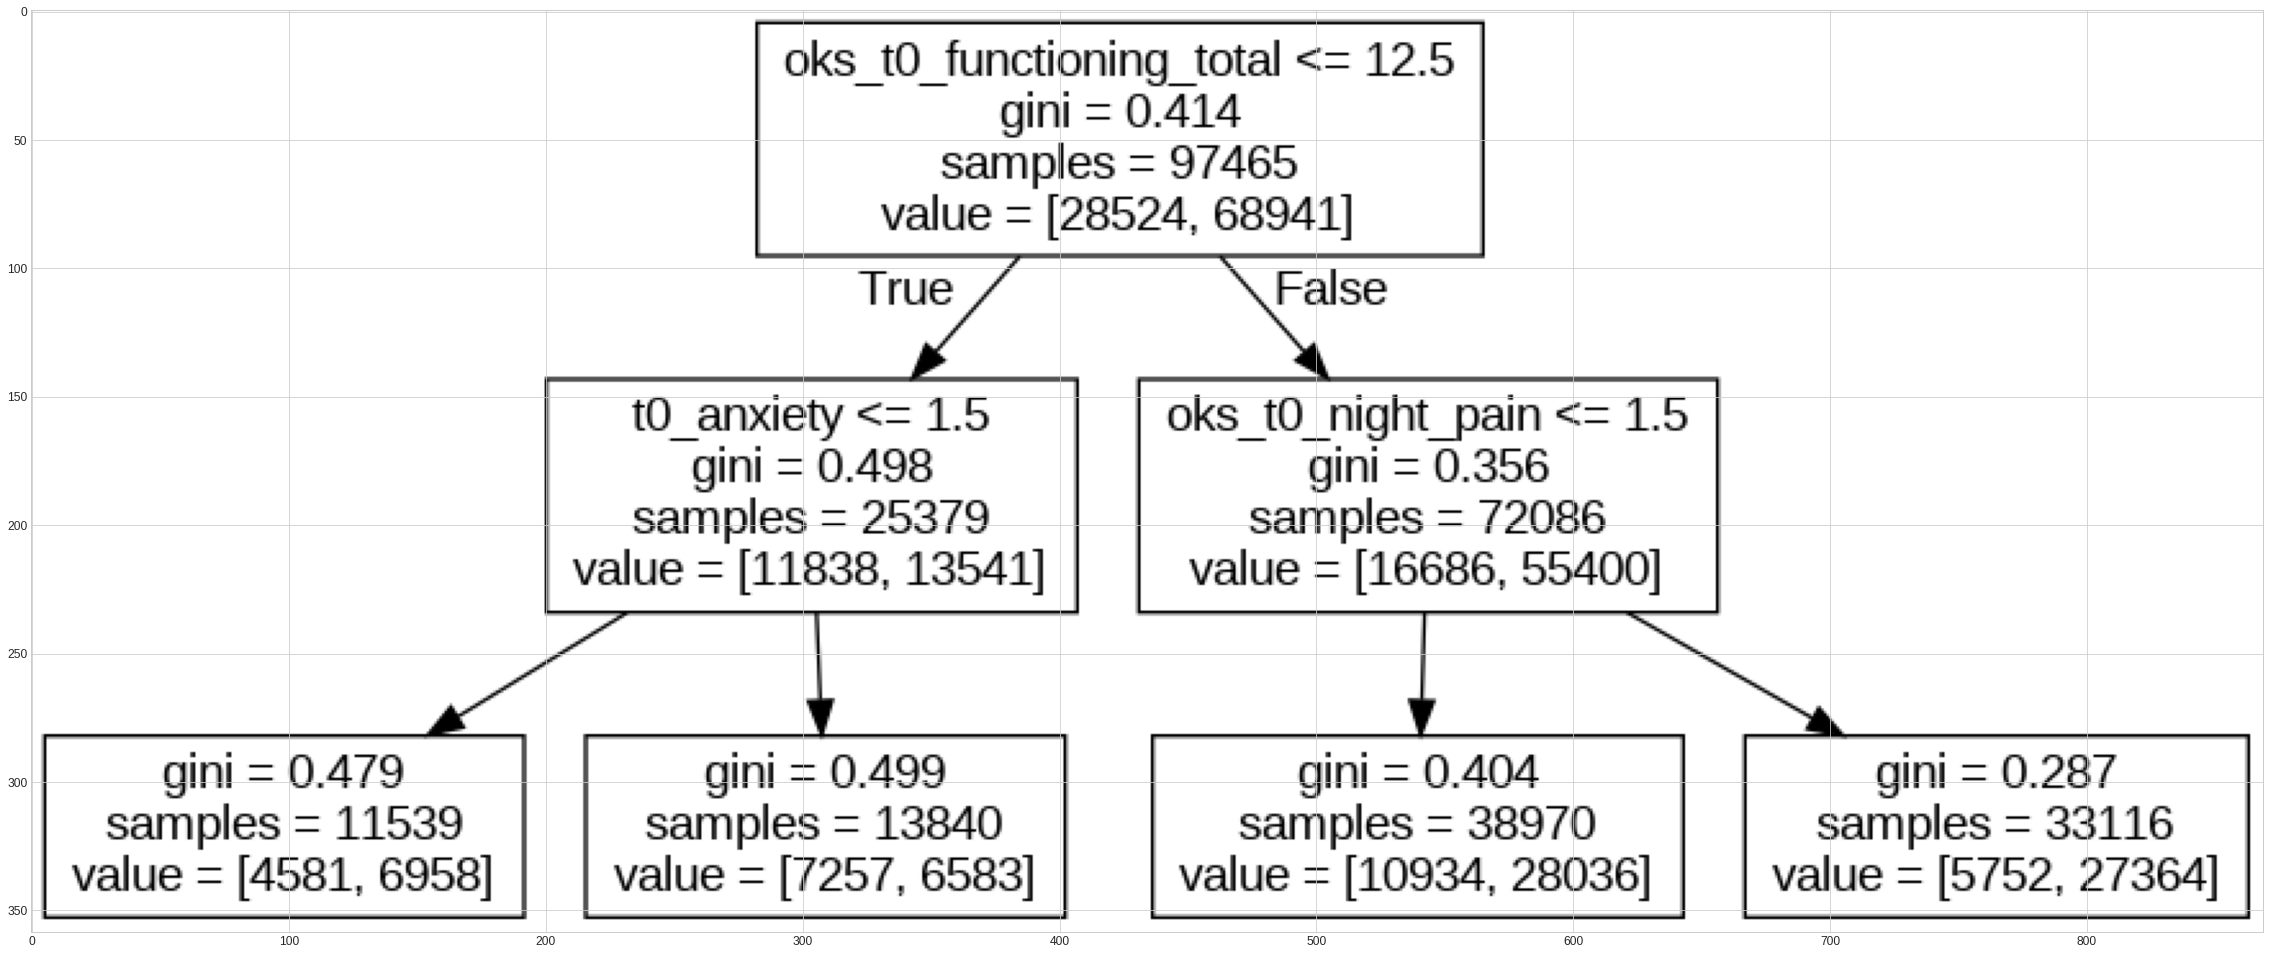

In [21]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread('tree.png')
plt.figure(figsize = (40, 40))
plt.imshow(img)

### Question 2
Rebuild the decision tree, and find better settings for the hyperparameters max_depth and min_samples_leaf.

### ROC curve
The ROC curve helps to visualize the tradeoff between sensitivity and specificity for different probability thresholds and can be generated using the code below. 

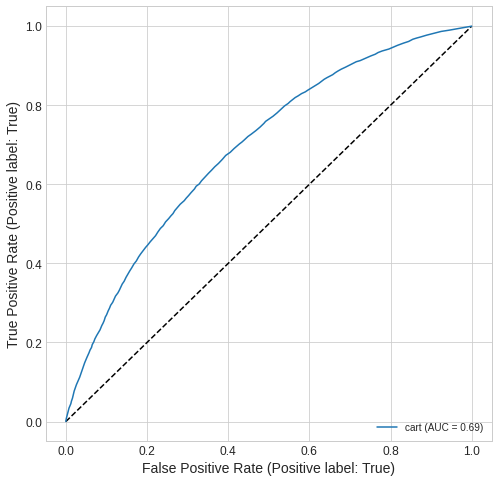

In [51]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

clfs = {
    "cart": cart_search2.best_estimator_,
}

fig_roc, ax_roc = plt.subplots(figsize=S)
plt.plot([0, 1], [0, 1], 'k--')
for k,v in clfs.items():
    RocCurveDisplay.from_estimator(v, df_test, y_test_binary, name=k, ax=ax_roc);

### PR curve
Below you find the precision recall curve for the decision tree. The precision-recall curve is typically more intuitive than the ROC curve.

Take some time to compare the two and familiarize yourself with these two trade-off curves. What do and what don't they tell you?

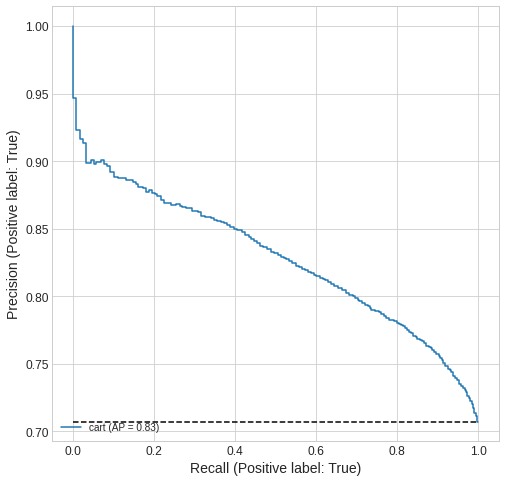

In [28]:
fig_prc, ax_prc = plt.subplots(figsize=S)
plt.plot([0,1], [ y1.iloc[1,1],  y1.iloc[1,1]], 'k--')
for k,v in clfs.items():
    PrecisionRecallDisplay.from_estimator(v, df_test, y_test_binary, name=k, ax=ax_prc)

##Random Forest

The next model is an extension of the decision tree just built. Random Forest is a so-called ensemble model, which combines multiple weak learners (in this case multiple decision trees), using an approach called 'bagging'.

In [29]:
%%time
from sklearn.ensemble import RandomForestClassifier


rf = Pipeline(
    steps=[("prep", prep), ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))]
)
rf_parameters = {
    "rf__max_samples": [1000],  # don't use the whole dataset: takes too long!
    "rf__n_estimators": [100],
    "rf__criterion": ["gini"],
    "rf__max_features": ["auto"],
    "rf__max_depth": [5, 15]
}
rf_search = GridSearchCV(rf, rf_parameters, scoring='roc_auc', cv=5)
_ = rf_search.fit(df_train, y_train_binary)

CPU times: user 8.15 s, sys: 428 ms, total: 8.58 s
Wall time: 19.2 s


In [30]:
rf_search.best_estimator_['rf']

RandomForestClassifier(max_depth=15, max_features='auto', max_samples=1000,
                       n_jobs=-1, random_state=42)

In [31]:
rf_search.cv_results_['mean_test_score'].max()

0.7006668202973566

In [32]:
confusion_matrix(y_train_binary, rf_search.best_estimator_.predict(df_train), normalize='all').round(3)

array([[0.07 , 0.223],
       [0.041, 0.666]])

We see that this Random Forest model, while hardly having tuned any hyperparameters, already performs slightly better than our best decision tree.

### Question 3

- Train a new random forest model and find better settings for the hyperparameters `max_features` and `max_depth`
- Extract the AUC values obtained on the validation folds
- Create the confusion matrix

## Gradient Boosting

Next, we will train Gradient Boosting models. The setup of the code is very similar, and it will be for most models, which is one of the great benefits of working with sklearn. 

The only difference is typically in the hyperparameters. You should have some theoretical understanding of the model, and look at the documentation available, to be able to determine which hyperparameters values make sense to try out during model development.

In [37]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

xgb = Pipeline(steps=[("prep", prep), ("xgb", GradientBoostingClassifier(random_state=42))])

xgb_parameters = {
    "xgb__subsample": [1.0], 
    "xgb__n_estimators": [200],
    "xgb__learning_rate": [0.1, 0.2],
    "xgb__max_features": [5, 10],
    "xgb__max_depth": [1, 2]
}
xgb_search = GridSearchCV(xgb, xgb_parameters, scoring='roc_auc', cv=5)
_ = xgb_search.fit(df_train, y_train_binary)


CPU times: user 4min 51s, sys: 329 ms, total: 4min 52s
Wall time: 4min 53s


In [38]:
xgb_search.best_estimator_['xgb']

GradientBoostingClassifier(learning_rate=0.2, max_depth=2, max_features=10,
                           n_estimators=200, random_state=42)

In [39]:
xgb_search.cv_results_['mean_test_score'].max()

0.714333133560849

We proceed by showing the confusion matrix, comparing modeled to true outcomes:

In [40]:
confusion_matrix(y_train_binary, xgb_search.predict(df_train), normalize='all').round(3)

array([[0.078, 0.215],
       [0.047, 0.66 ]])

### Question 4

- Train a new Gradient Boosting model and find better settings for the hyperparameters `n_estimators` and `learning rate`.
- Extract the AUC values obtained on the validation folds
- Create the confusion matrix

We can then compare the ROC and Precision-Recall curves for our Random Forest and Gradient Boosting models:

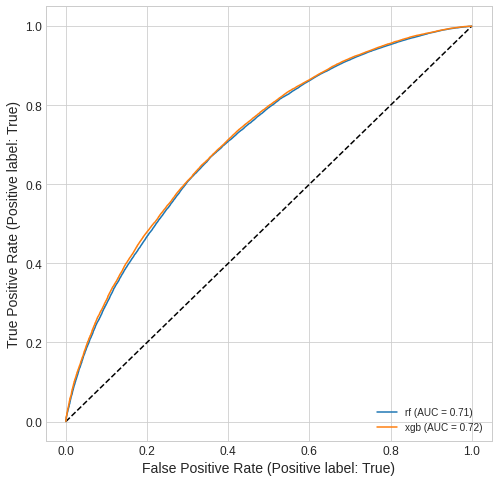

In [47]:
ensembles = {
    "rf": rf2_search.best_estimator_,
    "xgb": xgb2_search.best_estimator_,
}

fig_roc2, ax_roc2 = plt.subplots(figsize=S)
plt.plot([0, 1], [0, 1], 'k--')
for k,v in ensembles.items():
    RocCurveDisplay.from_estimator(v, df_train, y_train_binary, name=k, ax=ax_roc2)

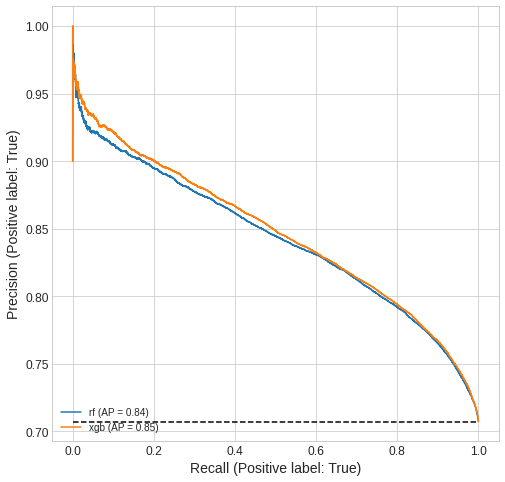

In [46]:
fig_prc2, ax_prc2 = plt.subplots(figsize=S)
plt.plot([0, 1], [y1.iloc[1,1], y1.iloc[1,1]], 'k--')
for k,v in ensembles.items():
    PrecisionRecallDisplay.from_estimator(v, df_train, y_train_binary, name=k, ax=ax_prc2)

### Question 5

So far we have only assessed performance on the train set. Plot the precision recall curves for the random forest and gradient boosting models for the test data and compare your results with the results based on the training data.

### Bonus Question 

Invert the outcome y_train_binary using np.invert, re-estimate a random forest or gradient boosting model, and again plot the precision-recall curve. Explain the differences with the precision recall curve for the original/uninverted binary outcome Y.

# Conclusion

We have now seen some of the most commonly used machine learning algorithms. There are many more algorithms available, and they all adhere to the same principles and can be applied in the same workflow as we have seen so far. Now that you are familiar with the data preparation pipeline, and with the way in which sklearn must be applied, it will be relatively easy to apply new types of models yourself. 

Next time, we will look at how to make generally uninterpretable models such as random forest or gradient boosting more understandable.

This was of course just a first glimpse of what it takes to build a model in the context of a data science project. If this would be a real project, you would put much more effort into data preparation, into choosing a clear outcome measure, setting a clear goal for how well models should perform to be of value to clinical practice, etc.

Nevertheless, these notebooks should give you a good overview of the steps taken in these kinds of analyses. Make sure to use these notebooks as a reference when working on your own data science project.